In [1]:
#Import necessary library packages to render HTML in a code cell
from IPython.display import HTML

#Define the javascript function and HTML to produce the show/hide code button
text = str('''
    <script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Show Code')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('Hide Code')
    }
    code_shown = !code_shown
  }

  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide()
  });
</script>
<form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Show Code"></form>''')

HTML(text)

In [2]:
# Script Content:
# Second Data Analytics Project
# Descriptive Analysis of OKCupid Profiles Data
# 1. Meta Analysis: Missing Values etc.
# 2. Basic Descriptive Stats
# 3. Essay Length/Ridgeline plots
# 4. Regional Analysis

# Authors: Andrew Boomer, Jacob Pichelmann

# Date: 19.03.2021

#### 0. Setup ####

## import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joypy
import os
import re
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from pandas.api.types import CategoricalDtype
from prettytable import PrettyTable
import warnings
from tabulate import tabulate
warnings.filterwarnings('ignore')

## set up paths

# Force the correct directory
if os.getcwd().split("/")[-1] == "CODE":
    os.chdir("..")
curr_dir = os.getcwd()

# If an output directory does not already exist, create one
if not os.path.isdir("OUTPUT"):
    os.mkdir("OUTPUT")
out_dir = curr_dir + "/OUTPUT/"


inp_dir = curr_dir + "/DATA/"

## import data

missing_values = ["nan", "-1"]  # account for income missing values = -1
df = pd.read_csv(inp_dir + '3-profiles.csv', na_values=missing_values)

In [3]:
# 0. Data preparation

## data prep
# generally for levels what about ''? --> no info
df['ethnicity_substr'] = df['ethnicity'].str.split().str[0].str.strip(',')

# df['religion_substr'] = df['religion'].str.split().str[0].str.strip('')
df['religion_level'] = df['religion'].apply(lambda x: " ".join(str(x).split(" ")[1:]))
df['religion'] = df['religion'].apply(lambda x: str(x).split(" ")[0])

# df['sign_substr'] = df['sign'].str.split().str[0].str.strip('')
df['sign_level'] = df['sign'].str.replace("&rsquo;", "'").apply(lambda x: " ".join(str(x).split(" ")[1:]))
df['sign'] = df['sign'].str.replace("&rsquo;", "'").apply(lambda x: str(x).split(" ")[0])

# strip html elements
essay_cols = df[[c for c in df if c.startswith('essay')]].columns
for col in essay_cols:
    df[col] =  [re.sub('<[^<]+?>','', str(x)) for x in df[col]]
    
# merge essays together
df['full_txt'] = df[essay_cols].apply(lambda row: ' '.join(row.values.astype(str)), axis=1)

# count total number of words written
df['count_txt'] = df.apply(lambda row : len(row['full_txt'].split()), axis = 1)

df['count_txt'].max() # +10k words seems unrealistic, drop heavy outliers? 

df['male'] = df['count_txt']
df['female'] = df['count_txt']
df.loc[df['sex']=='f', 'male'] = np.nan
df.loc[df['sex']=='m', 'female'] = np.nan

df = df[df['count_txt'] <= df['count_txt'].mean() + (4 * np.sqrt(df['count_txt'].var()))]

# Introduction

This report provides a descriptive analysis of the OKCupid data collected by Kim and Escobedo-Land (2015). The report is structured as follows:
1. We start by providing a meta analysis of the data. The goal of this first step is to highlight missing values and general characteristics of the data set that might limit the analysis.
2. We show descriptive statistics of all variables of interest. To provide a concise overview we distinguish between numerical and categorical variables. We provide interactive plots to allow the reader to familiarize him/herself with the data and highlight noteworthy features of the data.
3. Moving to the main findings of this report, we provide an in-depth analysis of the amount of text that individuals share on OKCupid. We do so by comparing the length of all user essays across several dimensions of characteristics. We see this as (1) a proxy of communicativeness and (2) as an indication of willigness to share personal data online. Analyzing this dimension of the data hence delivers interesting insights into both the personality types of different sets of users and their handling of personal data online. 
4. Lastly, we discuss alternative options to visualize the main findings and conclude. 

Given that the main purpose of a dating site is to connect people that are interested in a romantic relationship, we distinguish between male and female users whenever possible. We see this as a sensible approach, as the descriptive analysis also indicates that the share of bisexual or gay users is relatively low (see section XX for details).

# Meta Analysis
Before starting the actual analysis we need to check if there are caveats to the data which have to be accounted for. A heatmap of missing values delivers insights about data availability at a glance. We can see that the majority of users do not disclose their income. This otherwise highly interesting variable can hence not be seen as representative of the observed population. We therefore refrain from deriving conclusion from this variable. Similarly, we observe many missing values for the variable _offspring_, so any findings in this regard have to be taken with a grain of salt.

<AxesSubplot:>

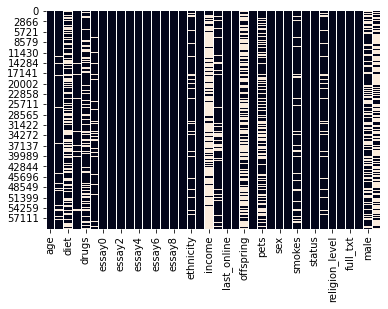

In [4]:
#### 1. Meta Analysis ####

sns.heatmap(df.isnull(), cbar=False)

# Descriptive Statistics

As outlined in the introduction we provide descriptive statistics of all variables of interest across males and females. Given the nature of the data at hand we start with a slightly unusal exercise. For a set of characteristics we record the most frequent value for male and female users separately. This gives an indication about how a typical 'hybrid' user looks like according to our data set. We then continue by analyzing the numerical variables in the data set. Here we provide both summary statistics and a line plots to XXXX. Finally, we move to the remaining categorical variables. As we are primarily interested in frequency counts we provide an interactive UI which returns a bar plot for the selected variable.

### Hybrid User
The table below shows the typical male and female users, i.e. the most common characteristics by group.

In [5]:
# 2.2.1
# what does most common man/women in data set look like?
# create helper function that returns most frequent characteristic

def max_freq(col, data = df):
    freq = data[col].value_counts().reset_index()
    freq_max = freq[freq[col] == max(freq[col])]['index'][0]
    return freq_max


males = df[df['sex'] == 'm']
females = df[df['sex'] == 'f']

cols = ['age', 'body_type', 'diet', 'drinks', 'drugs', 'education', 'ethnicity',
        'height', 'income', 'job']

res_male = []
for col in cols:
    res_male.append(max_freq(col, males))

res_female = []
for col in cols:
    res_female.append(max_freq(col, females))

# put results in a table
hybrid = pd.DataFrame({'F': res_female, 'M': res_male})
hybrid.index = cols

# display(hybrid) # we can print this in a sentence?
print(tabulate(hybrid, headers=['Female', 'Male'],
               tablefmt='fancy_grid', stralign='center', floatfmt='g'))


## Add sentence that describes hybrid user. 
print('We find that the typical OKCupid user is ... ')

╒═══════════╤═══════════════════════════════════╤═══════════════════════════════════╕
│           │              Female               │               Male                │
╞═══════════╪═══════════════════════════════════╪═══════════════════════════════════╡
│    age    │                25                 │                26                 │
├───────────┼───────────────────────────────────┼───────────────────────────────────┤
│ body_type │              average              │             athletic              │
├───────────┼───────────────────────────────────┼───────────────────────────────────┤
│   diet    │          mostly anything          │          mostly anything          │
├───────────┼───────────────────────────────────┼───────────────────────────────────┤
│  drinks   │             socially              │             socially              │
├───────────┼───────────────────────────────────┼───────────────────────────────────┤
│   drugs   │               never               │     

### Numerical variables

In the initial data set only 3 variables are numerical. We extend this set by 3 additional variables:
1. Number of words written by user across all essays.
2. Number of words in ethnicity (i.e. a measure of diversity).
3. Number of languages spoken by a user.

For each of these variables we provide total summary statistics and summary statistics by sex. Moreover, we provide line plots of all variables. We see that XXXXX

In [6]:
#### 2. Basic Descriptive Stats ####

# 2.1 Numerical variables
# 2.1.1 summary statistics
print(tabulate(df.describe(), headers='keys', tablefmt='fancy_grid', numalign='center', floatfmt='g'))

num_cats = ['age', 'income', 'height']

for num_cat in num_cats:
    disp = df.groupby(['sex'])[[num_cat]].describe()
    disp.columns = disp.columns.droplevel(0)
    print("\n\t\t\tDescribe Data For " + num_cat)
    print(tabulate(disp, headers='keys', tablefmt='fancy_grid', numalign='center', floatfmt='g'))

# 2.1.2 plots
def plot_line(data, num_cat):
    df.groupby([num_cat, 'sex']).size().unstack().plot()

interact(plot_line, data = fixed(df), num_cat = num_cats)

╒═══════╤═════════╤══════════╤══════════╤═════════════╤═════════╤══════════╕
│       │   age   │  height  │  income  │  count_txt  │  male   │  female  │
╞═══════╪═════════╪══════════╪══════════╪═════════════╪═════════╪══════════╡
│ count │  59561  │  59558   │  11397   │    59561    │  35580  │  23981   │
├───────┼─────────┼──────────┼──────────┼─────────────┼─────────┼──────────┤
│ mean  │ 32.3149 │ 68.2923  │  104564  │   348.007   │ 341.182 │ 358.134  │
├───────┼─────────┼──────────┼──────────┼─────────────┼─────────┼──────────┤
│ std   │ 9.44287 │ 3.99522  │  201586  │    256.3    │ 258.639 │ 252.455  │
├───────┼─────────┼──────────┼──────────┼─────────────┼─────────┼──────────┤
│ min   │   18    │    1     │  20000   │     10      │   10    │    10    │
├───────┼─────────┼──────────┼──────────┼─────────────┼─────────┼──────────┤
│ 25%   │   26    │    66    │  20000   │     160     │   150   │   176    │
├───────┼─────────┼──────────┼──────────┼─────────────┼─────────┼──────────┤

interactive(children=(Dropdown(description='num_cat', options=('age', 'income', 'height'), value='age'), Outpu…

<function __main__.plot_line(data, num_cat)>

### Categorical variables

For the remaining categorical variables our main interest lies in analyzing frequency counts to see if certain characteristics are more or less common. To get a concise understanding of the data at hand we provide an interactive tool where the user can select his/her variable of interest to obtain a barplot of said variable. However, for this to function properly serveral transformations of the data have to be done. We make the following data preparations

* **Ethnicity**: Users report every ethnicity they belong to, which yields an astonishing number of XX unique combinations of ethnicities. We construct another variable which takes only the first ethnicity a user reports, building on the assumption that the user reports his/her most relevant ethnicity first.
* **Religion/Sign**: For both religion and astrological sign users report jointly their affiliation and how serious they are about it. We split these two informations into distinct variables, as this holds more informational value and allows to find similarities between users who are e.g. serious about their religious beliefs, across religions.

From the these basic bar plots we can already derive intersting insights about the data.
* XXX
* XXX


In [7]:
df.columns

Index(['age', 'body_type', 'diet', 'drinks', 'drugs', 'education', 'essay0',
       'essay1', 'essay2', 'essay3', 'essay4', 'essay5', 'essay6', 'essay7',
       'essay8', 'essay9', 'ethnicity', 'height', 'income', 'job',
       'last_online', 'location', 'offspring', 'orientation', 'pets',
       'religion', 'sex', 'sign', 'smokes', 'speaks', 'status',
       'ethnicity_substr', 'religion_level', 'sign_level', 'full_txt',
       'count_txt', 'male', 'female'],
      dtype='object')

In [8]:
# 2.2.2 Categorical plots

categories = df[[c for c in df if not c.startswith('essay')]].columns.tolist()

exl = ['last_online', 'speaks', 'ethnicity', 'location']
categories = [c for c in categories if c not in exl]

def plot_bar(data, category):
    plt.figure()
    data = data.copy(deep=True)
    cat = CategoricalDtype(data[category].dropna().unique().tolist(), ordered=True)
    data[category] = data[category].astype(cat)
    data[category].replace('', 'no info', inplace=True) # account for empty strings
    
    sns.displot(data[data[category].notna()], x=category, hue="sex", multiple="dodge")
    plt.xticks(rotation=45, ha = 'right')
    # plt.savefig(out_dir + "Bar_" + category + ".png", bbox_inches='tight')
    plt.show
    
interact(plot_bar, data=fixed(df), category = categories)

interactive(children=(Dropdown(description='category', options=('age', 'body_type', 'diet', 'drinks', 'drugs',…

<function __main__.plot_bar(data, category)>

# Main findings

We now shift our focus to analyzing the communicativeness of OKCupid users. Given that the variable of interest is numerical we are interested in its distribution across different types of users. The granularity of the data allows answering highly interesting question i.e. whether religious individuals are more talkative than non religious (and if so, which religion leads the rank?) or if taking astrology seriously correlates with lengthier essays. We might even make an assessment whether or not vegans are really prone to over-sharing. For every one of those questions we again distinguish between male and female users. Given the large number of dimensions for many of the characteristics we visualize the distributions in small multiples, commonly denoted as ridge plots. This visualization allows the reader to immediately spot group differences, which is the goal of this analysis. 

The interactive framework below enables the reader to assess the communicativeness of users across multiple dimensions. We want to highlight the following interesting findings
* XXX
* XXX

In [9]:
#### 3. Essay Length/Ridgeline plots ####

def plot_ridgeline(data, category):
    # prep data
    data = data.copy(deep=True)
    if category not in ['age', 'height']: 
        cat = CategoricalDtype(data[category].dropna().unique().tolist(), ordered=True)
        data[category] = data[category].astype(cat)
        data[category].replace('', 'no info', inplace=True) # account for empty strings
    
    # plot
    plt.figure()
    joypy.joyplot(
    data=data[['male', 'female', category]], 
    by=category,
    x_range=(-250, 1500),
    column=['male', 'female'],
    ylim='own',
    figsize=(12, 8),
    legend=True,
    alpha = 0.6,
    grid='both')
    plt.title('Ridgeline Plot of Essay Length by ' + category + ' and Gender', fontsize=20)
    plt.savefig(out_dir + "Ridge_" + category + ".png", bbox_inches='tight')

interact(plot_ridgeline, data=fixed(df), category = categories)

interactive(children=(Dropdown(description='category', options=('age', 'body_type', 'diet', 'drinks', 'drugs',…

<function __main__.plot_ridgeline(data, category)>

# Alternative Visualization



# Appendix
## Data Dictionary

In [10]:
col_desc = {'age': "User Age in Years",
 'body_type': "User Reported Fitness Level",
 'diet': "User Reported Diet Preferences",
 'drinks':"User Reported Alcoholic Consumption",
 'drugs':"User Reported Drug Use Frequency",
 'education':"User Highest Level of Education Atttained",
 'essay0': "First Portion of User Essay",
 'essay1': "Second Portion of User Essay",
 'essay2': "Third Portion of User Essay",
 'essay3': "Fourth Portion of User Essay",
 'essay4': "Fifth Portion of User Essay",
 'essay5': "Sixth Portion of User Essay",
 'essay6': "Seventh Portion of User Essay",
 'essay7': "Eigth Portion of User Essay",
 'essay8': "Ninth Portion of User Essay",
 'essay9': "Tenth Portion of User Essay",
 'ethnicity': "User Reported Race/Ethnicity",
 'height': "User Reported Height in Inches",
 'income': "Annual Income in Dollars",
 'job': "Industry Sector of Employment",
 'last_online': "Last Login on Website in Minutes",
 'location': "City of User Residence",
 'offspring': "Whether User has Children and Wants Them",
 'orientation': "User Sexual Orientation",
 'pets': "User Preferences of Dogs and Cats",
 'religion': "General Religious Beliefs of User",
 'sex': "User Gender",
 'sign': "User Zodiac Sign",
 'smokes': "Frequency of Cigarette Smoking",
 'speaks': "Languages User Speaks",
 'status': "User Current Relationship Status"}

In [11]:
x = PrettyTable()
x.field_names = ['Column', 'Column Description']
x.add_rows(col_desc.items())

print(x)

+-------------+-------------------------------------------+
|    Column   |             Column Description            |
+-------------+-------------------------------------------+
|     age     |             User Age in Years             |
|  body_type  |        User Reported Fitness Level        |
|     diet    |       User Reported Diet Preferences      |
|    drinks   |    User Reported Alcoholic Consumption    |
|    drugs    |      User Reported Drug Use Frequency     |
|  education  | User Highest Level of Education Atttained |
|    essay0   |        First Portion of User Essay        |
|    essay1   |        Second Portion of User Essay       |
|    essay2   |        Third Portion of User Essay        |
|    essay3   |        Fourth Portion of User Essay       |
|    essay4   |        Fifth Portion of User Essay        |
|    essay5   |        Sixth Portion of User Essay        |
|    essay6   |       Seventh Portion of User Essay       |
|    essay7   |        Eigth Portion of 

<AxesSubplot:xlabel='height', ylabel='count_txt'>

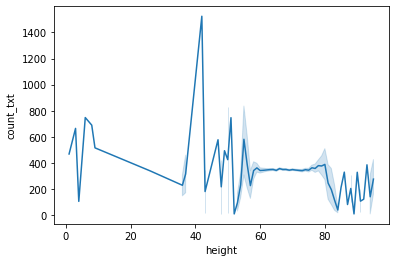

In [12]:
# sns.boxplot(data=df2, x='age', y='count_txt', orient='v')
sns.lineplot(data=df, x='height', y='count_txt')

In [13]:
cats = ['age', 'body_type', 'diet', 'drinks', 'drugs', 'education', 'ethnicity_substr', 'height', 'job', 'offspring', 
 'orientation', 'pets', 'religion', 'sign', 'smokes', 'speaks', 'status', 'ethnicity_substr', 'religion_level', 
 'sign_level']

In [14]:
#Box Plot to show only one categorical difference

In [15]:
df.loc[:, 'education_grp'] = ""
df.loc[:, 'education_grp'] = np.where(df['education'].str.contains("|".join(['masters', 'ph.d', 'med', 'law'])), 
    'Advanced Degree', np.where(df['education'].str.contains('university'), 'University Degree', 
    np.where(df['education'].str.contains('high schoool'), 'High School', 'Other')))
df.loc[:, 'age_grp'] = ""
df.loc[:, 'age_grp'] = np.where(df['age'] < 25, "Early 20's",
                            np.where(df['age'] < 30, "Late 20's",
                            np.where(df['age'] < 35, "Early 30's",
                            np.where(df['age'] < 40, "Late 30's",
                            np.where(df['age'] < 50, "40's",
                            np.where(df['age'] < 60, "50's", 'Over 60'))))))
df['offspring'] = df['offspring'].str.replace("&rsquo;", "'")
df['IsParent'] = np.where(df['offspring'].str.contains("has&kid"), "Has Children", "No Children")
df['FutureParent'] = np.where(df['offspring'].str.contains("doesn't want"), "No More Kids", "More Kids")
df['pet_grp'] = df['pets'].map({'likes dogs and likes cats' : 'Both', 'has cats' : 'Cat Person', 'likes cats' : 'Cat Person',
       'has dogs and likes cats' : 'Both', 'likes dogs and has cats' : 'Both',
       'likes dogs and dislikes cats' : 'Dog Person', 'has dogs' : 'Dog Person',
       'has dogs and dislikes cats' : 'Dog Person', 'likes dogs' : 'Dog Person',
       'has dogs and has cats' : 'Both', 'dislikes dogs and has cats' : 'Cat Person',
       'dislikes dogs and dislikes cats' : 'Neither', 'dislikes cats' : 'Dog Person',
        'dislikes dogs and likes cats' : 'Cat Person', 'dislikes dogs' : 'Cat Person'})

In [16]:
test = df.groupby(['sex'])[[num_cat]].describe()
test.columns = test.columns.droplevel(0)

In [17]:
print(tabulate(test, headers='keys', ))

sex      count     mean      std    min    25%    50%    75%    max
-----  -------  -------  -------  -----  -----  -----  -----  -----
f        23980  65.1026  2.92653      4     63     65     67     95
m        35578  70.4422  3.07699      1     68     70     72     95
